# Benchmark Cases: EGM & DC-EGM

In [1]:
import io
import yaml
import pickle
from typing import Dict, List

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.solve import solve_dcegm
from src.consumption_retirement_model import (
    utility_func_crra,
    inverse_marginal_utility_crra,
    compute_next_period_marginal_utility,
    # compute_value_function,
    # compute_value_function_final_period,
    compute_expected_value,
)

plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["figure.titlesize"] = "xx-large"
plt.rcParams["axes.labelsize"] = 14

In [2]:
def plot_optimal_consumption(
    policy: List[np.ndarray], params: pd.DataFrame, options: Dict[str, int]
) -> None:
    """Plots optimal consumption rules by age."""
    max_wealth = params.loc[("assets", "max_wealth"), "value"]
    n_periods = options["n_periods"]
    n_choices = options["n_discrete_choices"]

    if n_choices > 1:
        fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
        worker, retiree = 1, 0
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
        worker = 0
        
    fig.suptitle("Optimal Consumption Rules by Age")

    for period in range(n_periods - 1, -1, -1):

        ax.plot(policy[period][worker][0, :], policy[period][worker][1, :], linewidth=1)
        ax.set_xlim(0, max_wealth)
        ax.set_ylim(0, max_wealth)

        ax.set_xlabel("Wealth")
        ax.set_ylabel("Optimal Consumption")
        ax.set_title("Worker", fontweight="bold")
        
        
    if n_choices > 1:
        for period in range(n_periods - 1, -1, -1):

            ax2.plot(policy[period][retiree][0, :], policy[period][retiree][1, :], linewidth=1)
            ax2.set_xlim(0, max_wealth)
            ax2.set_ylim(0, max_wealth)

            ax2.set_xlabel("Wealth")
            ax2.set_title("Retiree", fontweight="bold")

    plt.tight_layout()
    
    
def plot_value_function(
    value: List[np.ndarray], params: pd.DataFrame, options: Dict[str, int]
) -> None:
    """Plots optimal consumption rules by age."""
    max_wealth = params.loc[("assets", "max_wealth"), "value"]
    n_periods = options["n_periods"]
    n_choices = options["n_discrete_choices"]
    
    if n_choices > 1:
        fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
        worker, retiree = 1, 0
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 9))
        worker = 0

    fig.suptitle("Value Functions by Age")

    for period in range(n_periods - 2, -1, -1):

        ax.plot(value[period][worker][0, :], value[period][worker][1, :], linewidth=1)
        ax.set_xlim(0, max_wealth)
        ax.set_ylim(-15, 15)

        ax.set_xlabel("Wealth")
        ax.set_ylabel("Value function")
        ax.set_title("Worker", fontweight="bold")
        
    if n_choices > 1:
        for period in range(n_periods - 2, -1, -1):

            ax2.plot(value[period][retiree][0, :], value[period][retiree][1, :], linewidth=1)
            ax2.set_xlim(0, max_wealth)
            ax2.set_ylim(-15, 15)

            ax2.set_xlabel("Wealth")
            ax2.set_title("Retiree", fontweight="bold")

    plt.tight_layout()

## Specify *utility functions*, *params* and *options*

In [3]:
utility_functions = {
    "utility": utility_func_crra,
    "inverse_marginal_utility": inverse_marginal_utility_crra,
    "next_period_marginal_utility": compute_next_period_marginal_utility,
}

In [4]:
params = """category,name,value,comment
beta,beta,0.95,discount factor
delta,delta,0,disutility of work
utility_function,theta,1,CRRA coefficient
wage,constant,0.75,age-independent labor income
wage,exp,0.04,return to experience
wage,exp_squared,-0.0004,return to experience squared
shocks,sigma,0.25,shock on labor income sigma parameter/standard deviation
shocks,lambda,0.00,taste shock (scale) parameter
assets,interest_rate,0.05,interest rate on capital
assets,initial_wealth_low,0,lowest level of inital wealth (relevant for simulation)
assets,initial_wealth_high,30,highest level of inital wealth (relevant for simulation)
assets,max_wealth,75,maximum level of wealth
assets,consumption_floor,0.0,consumption floor/retirement safety net (only relevant in the dc-egm retirement model)
"""

In [5]:
params = pd.read_csv(io.StringIO(params), index_col=["category", "name"])
params

value  \
category         name                           
beta             beta                  0.9500   
delta            delta                 0.0000   
utility_function theta                 1.0000   
wage             constant              0.7500   
                 exp                   0.0400   
                 exp_squared          -0.0004   
shocks           sigma                 0.2500   
                 lambda                0.0000   
assets           interest_rate         0.0500   
                 initial_wealth_low    0.0000   
                 initial_wealth_high  30.0000   
                 max_wealth           75.0000   
                 consumption_floor     0.0000   

                                                                                comment  
category         name                                                                    
beta             beta                                                   discount factor  
delta            delta                                               disutility of work  
utility_function theta                                                 CRRA coefficient  
wage             constant                                  age-independent labor income  
                 exp                                               return to experience  
                 exp_squared                               return to experience squared  
shocks           sigma                shock on labor income sigma parameter/standard...  
                 lambda                                   taste shock (scale) parameter  
assets           interest_rate                                 interest rate on capital  
                 initial_wealth_low   lowest level of inital wealth (relevant for si...  
                 initial_wealth_high  highest level of inital wealth (relevant for s...  
                 max_wealth                                     maximum level of wealth  
                 consumption_floor    consumption floor/retirement safety net (only ...

In [6]:
options = """n_periods: 25
min_age: 20
n_discrete_choices: 1
grid_points_wealth: 100
quadrature_points_stochastic: 10
n_simulations: 10
"""

In [7]:
options = yaml.safe_load(options)
options

{'n_periods': 25,
 'min_age': 20,
 'n_discrete_choices': 1,
 'grid_points_wealth': 100,
 'quadrature_points_stochastic': 10,
 'n_simulations': 10}

# 1) EGM: Consumption Savings Model with Income Shocks and Credit Constraint alla Deaton

In [8]:
policy_deaton, value_deaton = solve_dcegm(
    params, options, utility_functions, compute_expected_value,
)

In [9]:
# Compare with expected results from MATLAB
TEST_RESOURCES_DIR = "tests/resources/"

policy_expected = pickle.load(open(TEST_RESOURCES_DIR + "policy_deaton.pkl", "rb"))
value_expected = pickle.load(open(TEST_RESOURCES_DIR + "value_deaton.pkl", "rb"))


for period in range(23, -1, -1):
    for choice in [0]:
        np.testing.assert_array_almost_equal(
            policy_deaton[period, choice, :][
                :, ~np.isnan(policy_deaton[period, choice, :]).any(axis=0),
            ],
            policy_expected[period, choice],
        )
        np.testing.assert_array_almost_equal(
            value_deaton[period, choice, :][
                :, ~np.isnan(value_deaton[period, choice, :]).any(axis=0),
            ],
            value_expected[period, choice],
        )

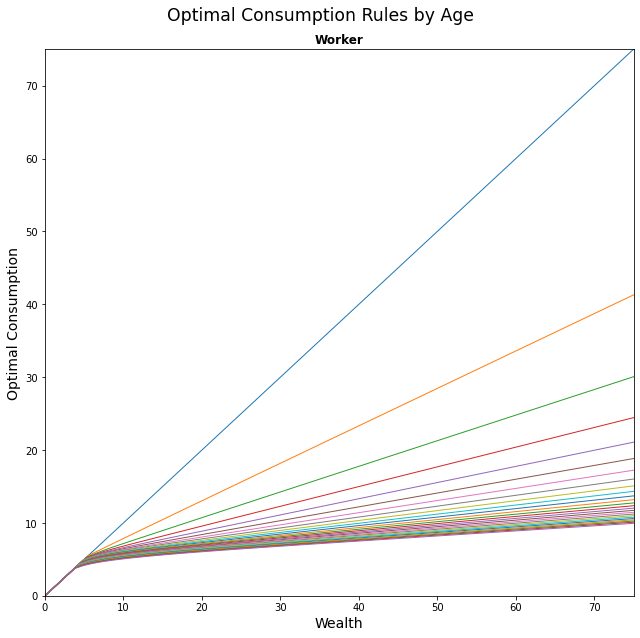

In [10]:
plot_optimal_consumption(policy_deaton, params, options)

In [11]:
# The older the agent, the steeper (more positive) the curve (i.e. the more is consumed
# and the less is saved).

# Final period, everything consumed, nothing saved

# 2) DC-EGM: Retirement Model

## a) Without taste shocks

### Update *params* and *options*

In [12]:
params.loc[("beta", "beta"), "value"] = 0.95
params.loc[("delta", "delta"), "value"] = 0.35
params.loc[("utility_function", "theta"), "value"] = 1.95
params.loc[("wage", "exp_squared"), "value"] = -0.0002
params.loc[("shocks", "sigma"), "value"] = 0.00
params.loc[("shocks", "lambda"), "value"] = 2.2204e-16
params.loc[("assets", "max_wealth"), "value"] = 50
params.loc[("assets", "consumption_floor"), "value"] = 0.001

params.loc[("beta", "beta"), "value"] = 0.95
params.loc[("shocks", "sigma"), "value"] = 0.00
params.loc[("shocks", "lambda"), "value"] = 2.2204e-16

In [13]:
options["n_discrete_choices"] = 2
options["grid_points_wealth"] = 500
options["quadrature_points_stochastic"] = 5

In [14]:
policy_retirement, value_retirement = solve_dcegm(
    params, options, utility_functions, compute_expected_value
)

segments_non_mono: 3
value_refined: (2, 483), points_to_add: (2, 1)
index_dominated_points: (19,)
segments_non_mono: 3
value_refined: (2, 486), points_to_add: (2, 1)
index_dominated_points: (16,)
segments_non_mono: 5
value_refined: (2, 477), points_to_add: (2, 2)
index_dominated_points: (26,)
segments_non_mono: 7
value_refined: (2, 519), points_to_add: (2, 3)
index_dominated_points: (33,)
segments_non_mono: 7
value_refined: (2, 476), points_to_add: (2, 3)
index_dominated_points: (28,)
segments_non_mono: 9
value_refined: (2, 470), points_to_add: (2, 4)
index_dominated_points: (35,)
segments_non_mono: 9
value_refined: (2, 473), points_to_add: (2, 4)
index_dominated_points: (32,)
segments_non_mono: 11
value_refined: (2, 471), points_to_add: (2, 5)
index_dominated_points: (35,)
segments_non_mono: 13
value_refined: (2, 469), points_to_add: (2, 6)
index_dominated_points: (38,)
segments_non_mono: 13
value_refined: (2, 474), points_to_add: (2, 6)
index_dominated_points: (33,)
segments_non_mono

In [15]:
with open(TEST_RESOURCES_DIR + "policy_retirement_no_taste_shocks.pkl", 'rb') as file : 
    policy_expected = pickle.load(file)
with open(TEST_RESOURCES_DIR + "value_retirement_no_taste_shocks.pkl", 'rb') as file : 
    value_expected = pickle.load(file)

for period in range(23, -1, -1):
    for choice in [1,0]:
        np.testing.assert_array_almost_equal(
            policy_retirement[period, choice, :][
                :, ~np.isnan(policy_retirement[period, choice, :]).any(axis=0),
            ],
            policy_expected[period][choice].T,
        )
        np.testing.assert_array_almost_equal(
            value_retirement[period, choice, :][
                :, ~np.isnan(value_retirement[period, choice, :]).any(axis=0),
            ],
            value_expected[period][choice].T,
        )


Note the kinks in the value function of the worker and discontinuities in the optimal consumption rules.

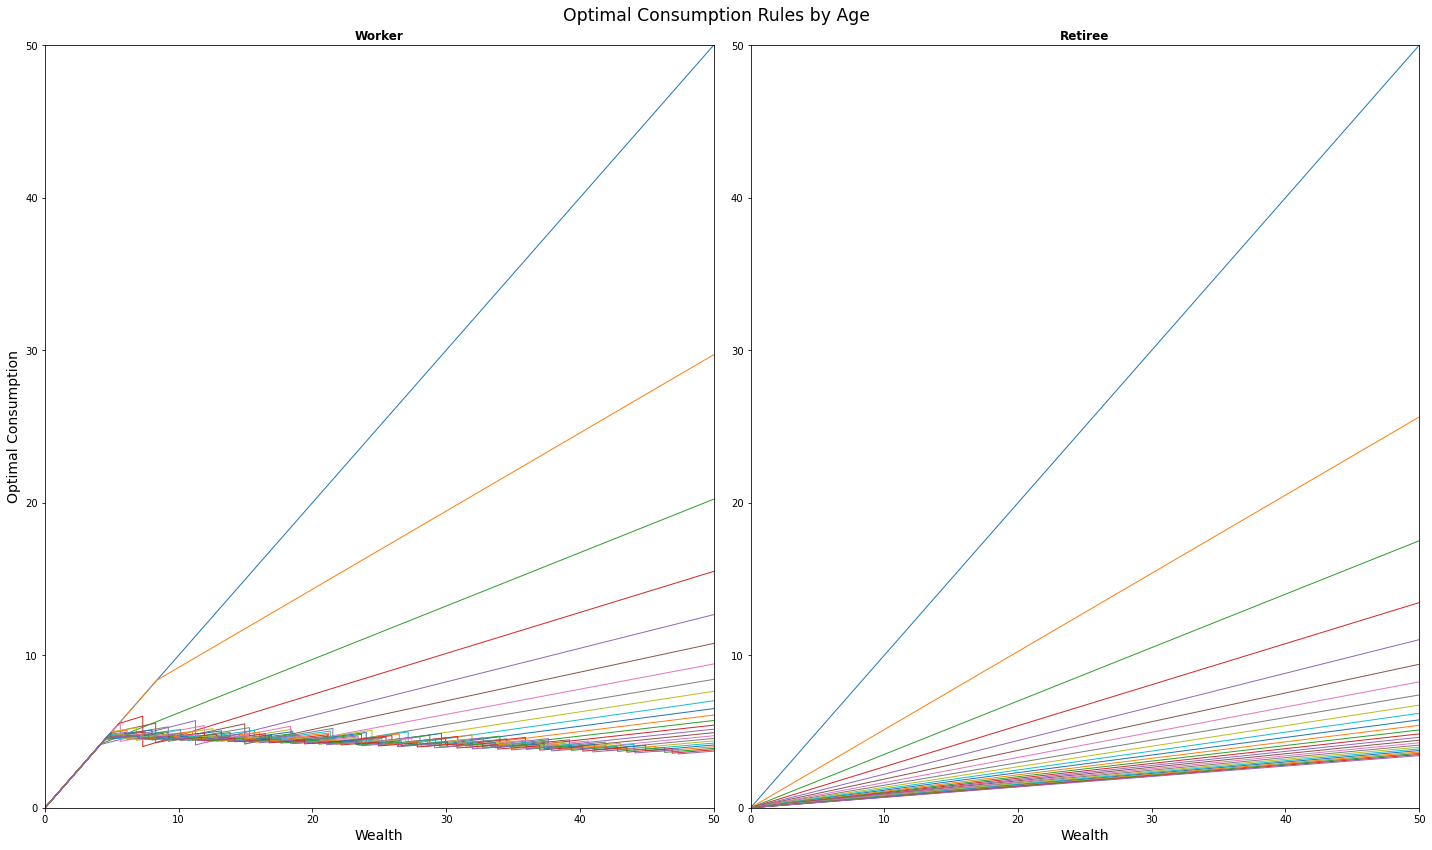

In [16]:
plot_optimal_consumption(policy_retirement, params, options)

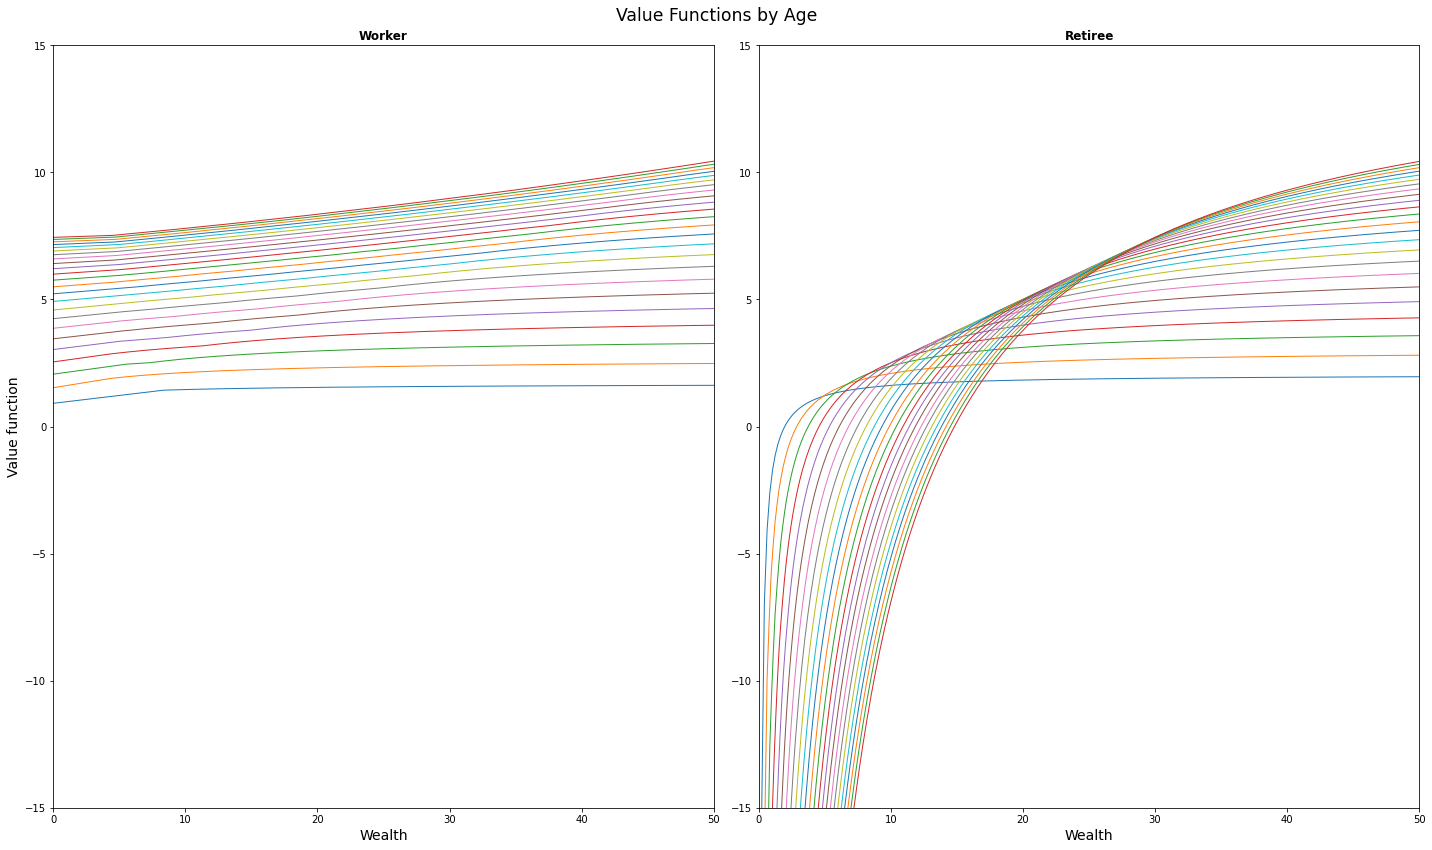

In [17]:
plot_value_function(value_retirement, params, options)

## b) With taste shocks

### Update *params*

In [18]:
r = params.loc[("assets", "interest_rate"), "value"]
params.loc[("beta", "beta"), "value"] = 1 / (1 + r)
params.loc[("shocks", "sigma"), "value"] = 0.35
params.loc[("shocks", "lambda"), "value"] = 0.2

In [19]:
policy_retirement, value_retirement = solve_dcegm(
    params, options, utility_functions, value_functions,
)

In [20]:
with open(TEST_RESOURCES_DIR + "policy_retirement_taste_shocks.pkl", 'rb') as file : 
    policy_expected = pickle.load(file)
with open(TEST_RESOURCES_DIR + "value_retirement_taste_shocks.pkl", 'rb') as file : 
    value_expected = pickle.load(file)

for period in range(23, -1, -1):
    for choice in [1,0]:
        np.testing.assert_array_almost_equal(policy_retirement[period][choice], policy_expected[period][choice].T)
        np.testing.assert_array_almost_equal(value_retirement[period][choice], value_expected[period][choice].T)

The kinks in the value function of the worker and discontinuities in the optimal consumption rules are smoothed with extreme value distributed taste shocks

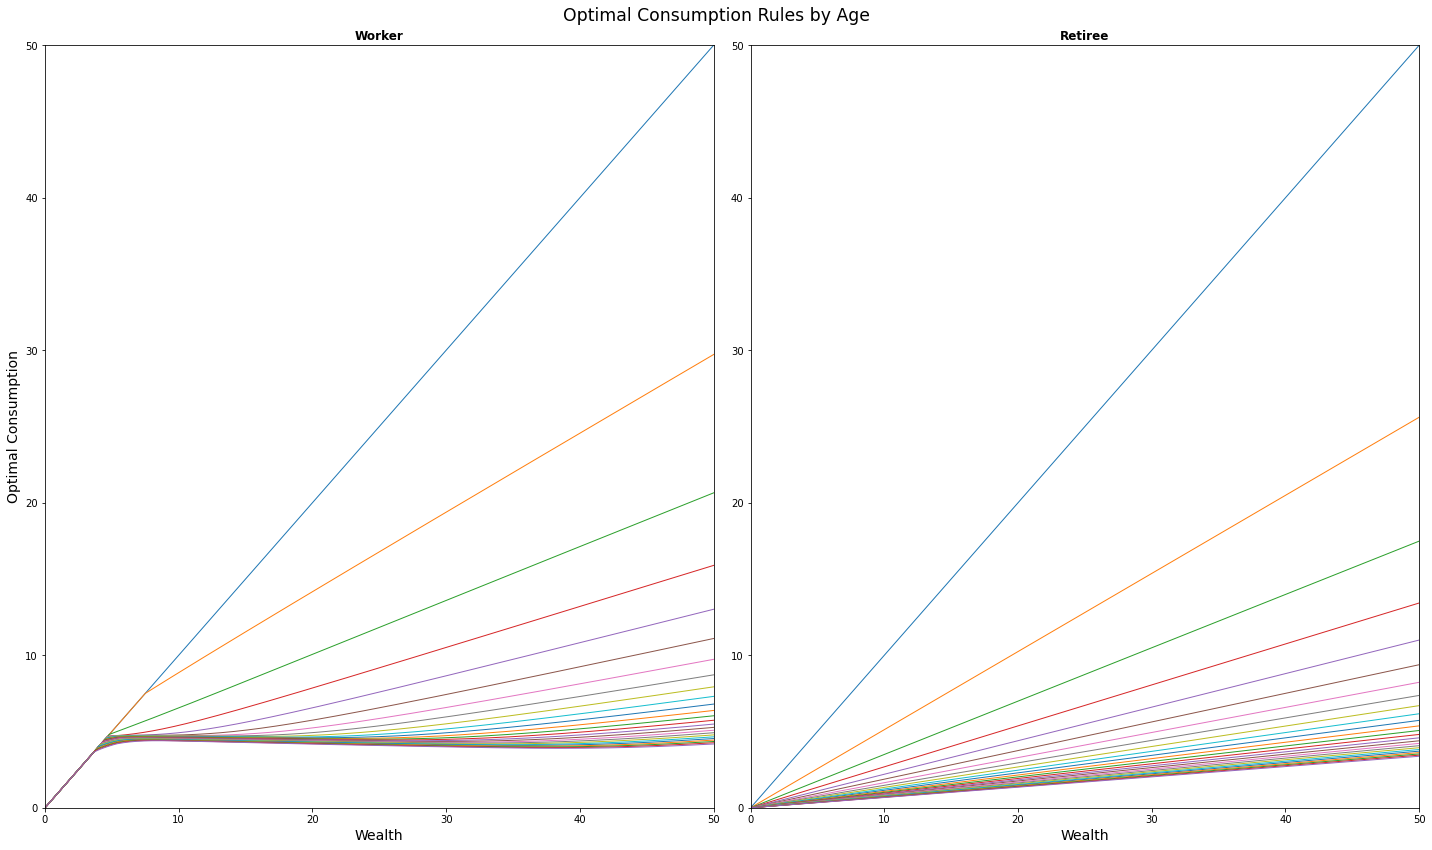

In [21]:
plot_optimal_consumption(policy_retirement, params, options)

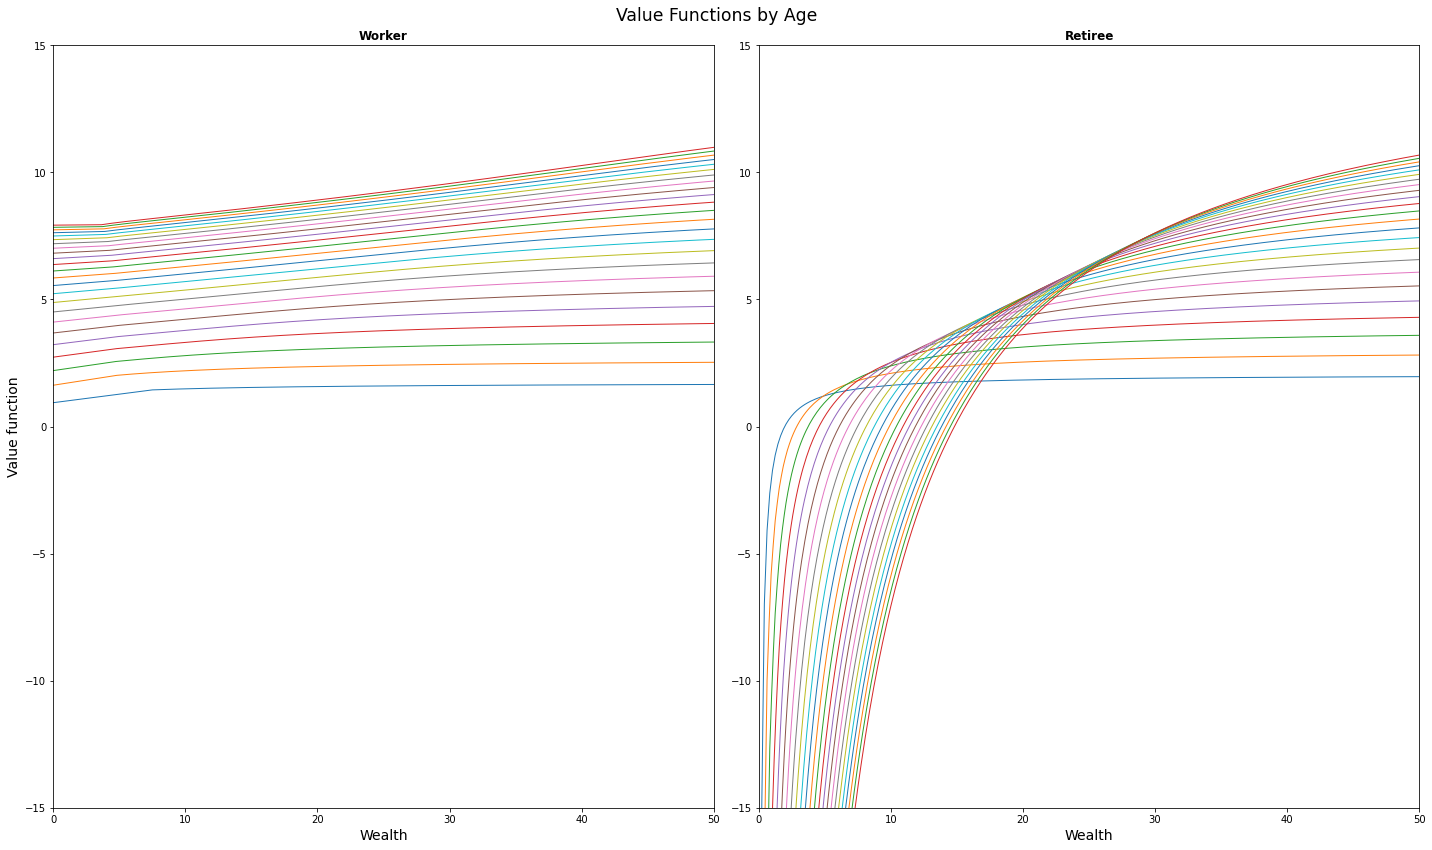

In [22]:
plot_value_function(value_retirement, params, options)